In [1]:
from sklearn.preprocessing import LabelEncoder
from PIL import Image
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
import splitfolders
import shutil
import os
from tensorflow.keras.layers import Flatten
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess_input
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip
from tensorflow.keras.layers.experimental.preprocessing import RandomRotation
from tqdm import tqdm
import time
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.manifold import TSNE
from matplotlib.image import imread
import cv2
from os import listdir
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
# %matplotlib inline



In [2]:

Image.MAX_IMAGE_PIXELS = None



In [3]:
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")



  # Import des données

In [4]:
path = "C:/Users/Helene/Documents/03_DataScience/02_FORMATION/OpenClassRooms/01_PROJETS/P6/01_DATA/Flipkart/Images/"
list_photos = [file for file in listdir(path)]
print(len(list_photos))



1050


In [5]:
data = pd.read_csv(
    '../01_DATA/target.csv')
data = data.drop('Unnamed: 0', axis=1)
data = data.rename(columns={'categ_0': 'label'})



In [6]:
labels = data["label"]



In [7]:
# transormation des labels en entiers (nécessaire pour calculer matrice de confusion)
labelencoder = LabelEncoder()
labelencoder.fit(labels)
labels_int = labelencoder.transform(labels)
labels_int



array([4, 0, 0, ..., 0, 0, 0])

In [8]:
list_labels = data.label.sort_values().unique()
list_labels


array(['Baby Care ', 'Beauty and Personal Care ', 'Computers ',
       'Home Decor & Festive Needs ', 'Home Furnishing ',
       'Kitchen & Dining ', 'Watches '], dtype=object)

  # Définition des fonctions communes

In [9]:


def visu_resultats(features, y_pred, ARI, y_true=data.label):
    # Visualisation sur tsne
    tsne = TSNE(n_components=2, init='pca', random_state=0)
    X_tsne = tsne.fit_transform(features)

    plt.figure(figsize=(24, 6))
    plt.subplot(1, 3, 1)
    sns.scatterplot(X_tsne[:, 0], X_tsne[:, 1], hue=y_true)
    plt.legend(bbox_to_anchor=(1, 1))
    plt.title("Catégorisation de référence")

    plt.subplot(1, 3, 2)
    sns.scatterplot(X_tsne[:, 0], X_tsne[:, 1], hue=y_pred)
    plt.legend(bbox_to_anchor=(1, 1))
    plt.title("Résultat du clustering automatique\nARI = {:.3f}".format(ARI))

    plt.subplot(1, 3, 3)
    plt.hist(x=y_pred, bins=7)



In [10]:


def feature_extraction(model, data, path, preprocess_input):
    # retrait dernière couche
    feat_extr_model = Model(inputs=model.inputs,
                            outputs=model.layers[-2].output)
    taille_vecteur = model.layers[-2].output.shape[1]

    compteur = 0
    image_features_all = np.empty(shape=(0, taille_vecteur))
    for img in tqdm(data.image):
        filename = path + img
        image = load_img(filename, target_size=(224, 224))
        # convert the image pixels to a numpy array
        image = img_to_array(image)
        # reshape data for the model
        image = image.reshape(
            (1, image.shape[0], image.shape[1], image.shape[2]))
        # prepare the image for the VGG model
        image = preprocess_input(image)
        # get extracted features
        img_features = feat_extr_model(image)
        image_features_all = np.concatenate(
            (image_features_all, img_features), axis=0)
        compteur += 1
    return image_features_all



In [11]:


def clustering_7classes(X, labels):
    cls = KMeans(n_clusters=7, random_state=0)
    cls.fit(X)

    y_pred = cls.labels_

    ARI = adjusted_rand_score(labels, y_pred)
    print("ARI : {:.2f}".format(ARI))
    return y_pred, ARI



In [12]:


def reduction_dimension(X):
    print("Réduction de dimension")
    print('ACP')
    print("Dimensions dataset avant réduction PCA : ", X.shape)
    pca = PCA(n_components=0.99, random_state=0)
    feat_pca = pca.fit_transform(X)
    print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

    return feat_pca



In [13]:
def erreur_attribution(y_true, y_pred, labels=labels):
    '''
    calcul et affichage de la matrice de confusion pour identifier
    les classes qui sont bien prédites
    '''
    # Calcul de la matrice de confusion
    conf_mat = confusion_matrix(y_true=y_true, y_pred=y_pred)
    # Alignement le long de la diagonale
    corresp = np.argmax(conf_mat, axis=0)
    print("Correspondance des clusters : ", corresp)
    labels_df = pd.Series(labels, name="labels").to_frame()
    labels_df['y_true'] = y_true
    labels_df['y_pred'] = y_pred
    labels_df['y_pred_transform'] = labels_df['y_pred'].apply(
        lambda x: corresp[x])
    # re-calcul de la nouvelle matrice de confusion
    conf_mat = confusion_matrix(y_true, labels_df.y_pred_transform)
    print(classification_report(y_true, labels_df.y_pred_transform))
    # visu
    corresp = pd.DataFrame(corresp, columns=['corresp'])
    corresp = corresp.sort_values(by='corresp', axis=0)
    index = list(corresp.index)
    df_cm = pd.DataFrame(conf_mat, index=[label for label in list_labels],
                         columns=[i for i in index])
    plt.figure(figsize=(8, 6))
    sns.heatmap(df_cm, annot=True, cmap="Blues")


# CNN - Transfer Learning :
# EXTRACTION DE FEATURES
    Utilisation d'un CNN déjà pré-entrainé pour calculer les features des images. Ces features seront utilisées dans un kmeans pour vérifier si on arrive à classer correctement ces images ou non

## VGG16

In [14]:
# Charger VGG-16 pré-entraîné sur ImageNet et sans les couches fully-connected
my_vgg16 = VGG16()
my_vgg16.summary()



Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

### Test sur une image
    N'accepte pas des images de tailles différentes ni passées en NB (arg grayscale=True à l'import)

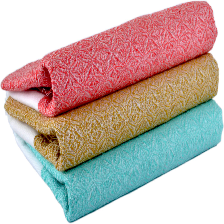

In [15]:
# load an image from file
filename = path + data.image[1]
image = load_img(filename, target_size=(224, 224))
image



In [16]:
type(image)



PIL.Image.Image

In [17]:
# convert the image pixels to a numpy array
image = img_to_array(image)
image.shape



(224, 224, 3)

In [18]:
# confirm pixel range is 0-255
print('Data Type: %s' % image.dtype)
print('Min: %.3f, Max: %.3f' % (image.min(), image.max()))



Data Type: float32
Min: 0.000, Max: 255.000


In [19]:
# Pas necessaire car j'utilise preprocess_input qui prépare les images de façon à ce que ce soit compatible avec le preprocessing d'ImageNet

# # Normalisation de l'image
# # normalize to the range 0-1
# image /= 255.0
# # confirm the normalization
# print('Min: %.3f, Max: %.3f' % (image.min(), image.max()))
# image.shape



  centrage de l'image.
  plusieurs stratégies existent :
  - centrage global : à partir de la moyenne de l'image (tout canaux inclus)
  - centrage local : à partir de la moyenne de chaque canal
  - possibilité aussi de s'appuyer sur les moyennes calculées à partir du jeu d'entrainement imageNet sur lequel a été entrainé le vgg16

In [20]:
# reshape data for the model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
image.shape



(1, 224, 224, 3)

In [21]:
# prepare the image for the VGG model
image = vgg16_preprocess_input(image)
image.shape
print('Min: %.3f, Max: %.3f' % (image.min(), image.max()))



Min: -123.680, Max: 151.061


In [22]:
# remove the output layer
my_vgg16 = Model(inputs=my_vgg16.inputs, outputs=my_vgg16.layers[-2].output)
my_vgg16.summary()



Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [23]:
# get extracted features
features = my_vgg16.predict(image)
print(features.shape)



(1, 4096)


In [24]:
type(features)



numpy.ndarray

In [25]:
features



array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

### Pour toutes les images

In [26]:
# load model
model = VGG16()

image_features_vgg16 = feature_extraction(
    model=model, data=data, path=path, preprocess_input=vgg16_preprocess_input)



100%|██████████| 1050/1050 [03:38<00:00,  4.81it/s]


In [27]:
image_features_vgg16.shape



(1050, 4096)

In [28]:
image_features_vgg16



array([[3.39861631, 0.85957229, 0.        , ..., 0.        , 0.85105467,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 1.29709888, 0.        ,
        0.        ],
       ...,
       [2.19612956, 2.3982749 , 2.62364101, ..., 2.15987325, 0.18472263,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.24832913,
        0.92513758],
       [0.        , 0.        , 0.12313122, ..., 0.        , 0.52771586,
        2.99174953]])

### Clustering + ARI

In [29]:
# calcul 7 categories (kmeans)
y_pred_vgg16, ARI_vgg16 = clustering_7classes(
    X=image_features_vgg16, labels=labels)



ARI : 0.46


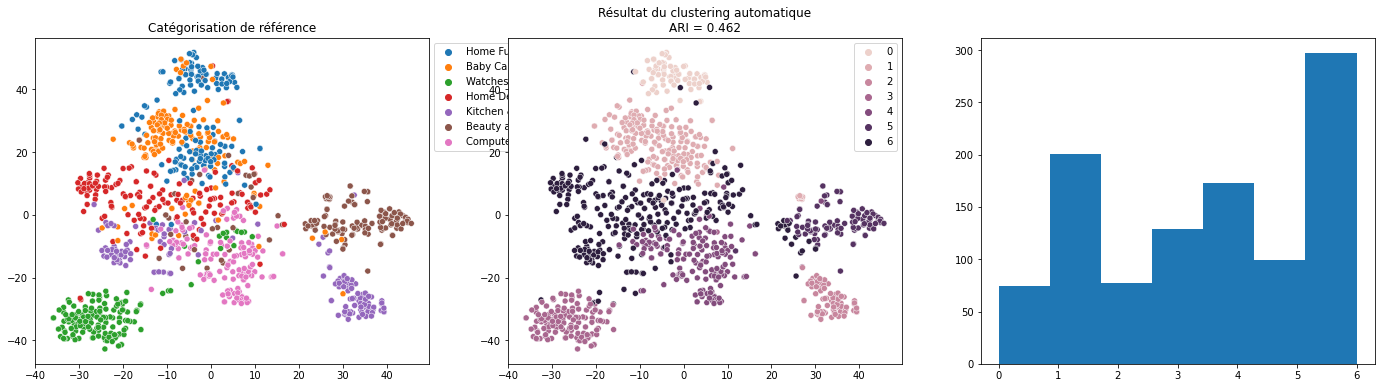

In [30]:
# Visualisation sur tsne
visu_resultats(features=image_features_vgg16,
               y_pred=y_pred_vgg16, ARI=ARI_vgg16)



Correspondance des clusters :  [4 0 5 6 2 1 3]
              precision    recall  f1-score   support

           0       0.53      0.71      0.60       150
           1       0.96      0.63      0.76       150
           2       0.77      0.89      0.83       150
           3       0.47      0.94      0.63       150
           4       0.82      0.41      0.54       150
           5       0.99      0.51      0.67       150
           6       0.98      0.85      0.91       150

    accuracy                           0.70      1050
   macro avg       0.79      0.70      0.71      1050
weighted avg       0.79      0.70      0.71      1050



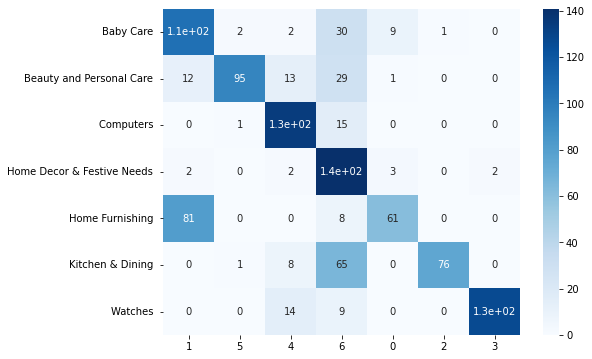

In [31]:
erreur_attribution(y_true=labels_int, y_pred=y_pred_vgg16)


### Reduction de dimension (ACP) + clustering

In [32]:
# Réduction de dimension
feat_pca_vgg16 = reduction_dimension(X=image_features_vgg16)

# Classification finale
y_pred_vgg16, ARI_vgg16 = clustering_7classes(X=feat_pca_vgg16, labels=labels)



Réduction de dimension
ACP
Dimensions dataset avant réduction PCA :  (1050, 4096)
Dimensions dataset après réduction PCA :  (1050, 803)
ARI : 0.48


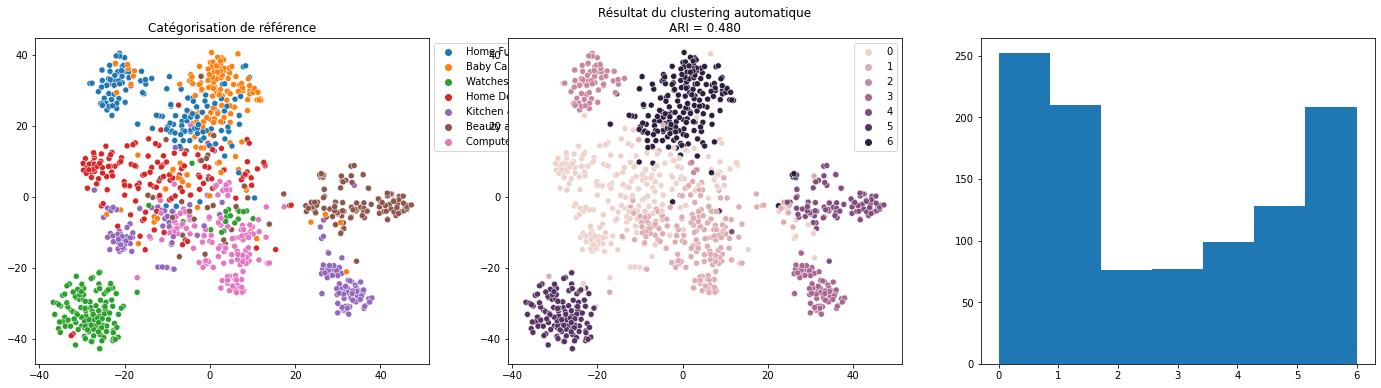

In [33]:
# Visualisation sur tsne
visu_resultats(features=feat_pca_vgg16, y_pred=y_pred_vgg16, ARI=ARI_vgg16)



Correspondance des clusters :  [3 2 4 5 1 6 0]
              precision    recall  f1-score   support

           0       0.52      0.73      0.61       150
           1       0.96      0.63      0.76       150
           2       0.68      0.95      0.79       150
           3       0.54      0.91      0.68       150
           4       0.82      0.41      0.55       150
           5       0.99      0.51      0.67       150
           6       0.98      0.84      0.91       150

    accuracy                           0.71      1050
   macro avg       0.78      0.71      0.71      1050
weighted avg       0.78      0.71      0.71      1050



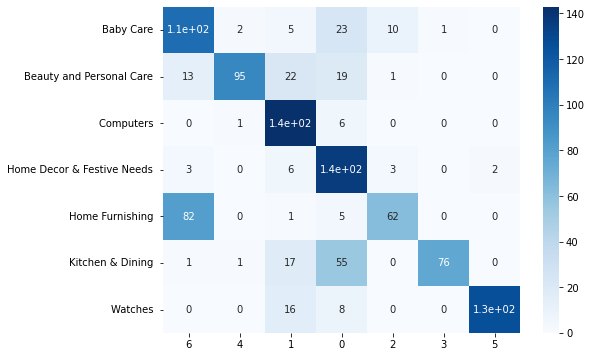

In [34]:
erreur_attribution(y_true=labels_int, y_pred=y_pred_vgg16)


   ### Autre façon de définir le modèle

In [35]:
# load model
model = VGG16(include_top=False, weights='imagenet', pooling='avg')

model.summary()



Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [36]:
compteur = 0
image_features_vgg16_2 = np.empty(shape=(0, 512))
for img in tqdm(data.image):
    filename = path + img
    image = load_img(filename, target_size=(224, 224))
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    # reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # prepare the image for the VGG model
    image = vgg16_preprocess_input(image)
    # get extracted features
    img_features = model(image)
    image_features_vgg16_2 = np.concatenate(
        (image_features_vgg16_2, img_features), axis=0)
    compteur += 1



100%|██████████| 1050/1050 [03:15<00:00,  5.38it/s]


In [37]:
# calcul 7 categories (kmeans)
y_pred_vgg16_2, ARI_vgg16_2 = clustering_7classes(
    X=image_features_vgg16_2, labels=labels)



ARI : 0.35


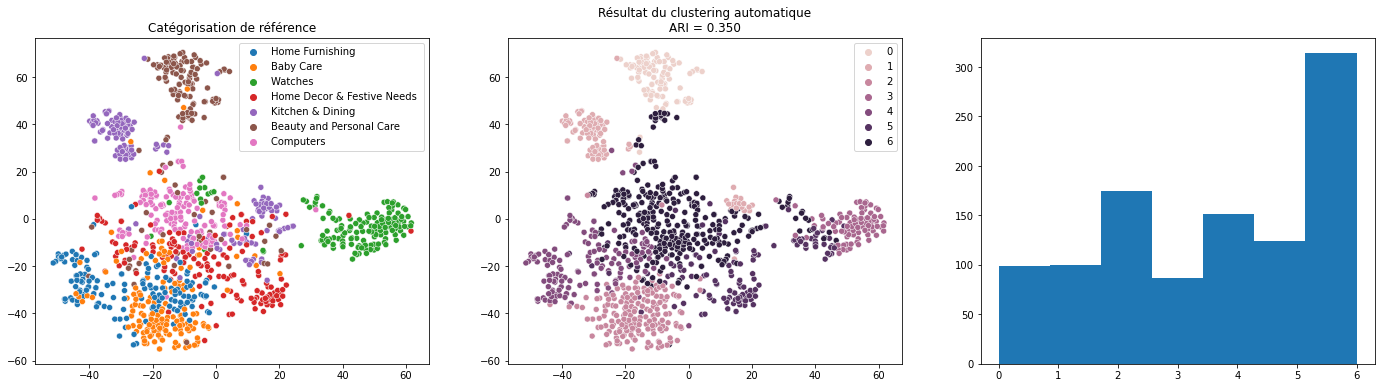

In [38]:
# Visualisation sur tsne
visu_resultats(features=image_features_vgg16_2,
               y_pred=y_pred_vgg16_2, ARI=ARI_vgg16_2)



Correspondance des clusters :  [1 5 0 6 4 3 2]
              precision    recall  f1-score   support

           0       0.59      0.69      0.63       150
           1       0.96      0.63      0.76       150
           2       0.44      0.93      0.60       150
           3       0.62      0.51      0.56       150
           4       0.46      0.47      0.47       150
           5       0.99      0.66      0.79       150
           6       0.98      0.57      0.72       150

    accuracy                           0.64      1050
   macro avg       0.72      0.64      0.65      1050
weighted avg       0.72      0.64      0.65      1050



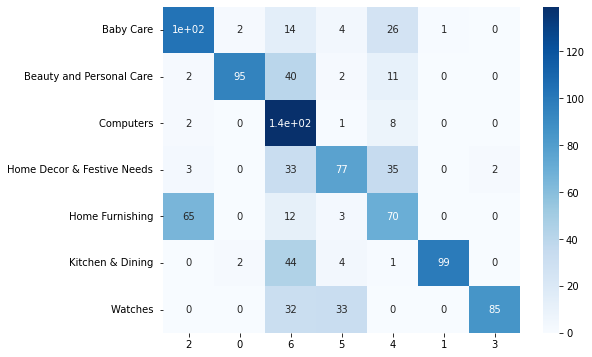

In [39]:
erreur_attribution(y_true=labels_int, y_pred=y_pred_vgg16_2)


In [40]:
# Réduction de dimension
feat_pca_vgg16_2 = reduction_dimension(X=image_features_vgg16_2)

# Classification finale
y_pred_vgg16_2, ARI_vgg16_2 = clustering_7classes(
    X=feat_pca_vgg16_2, labels=labels)



Réduction de dimension
ACP
Dimensions dataset avant réduction PCA :  (1050, 512)
Dimensions dataset après réduction PCA :  (1050, 351)
ARI : 0.33


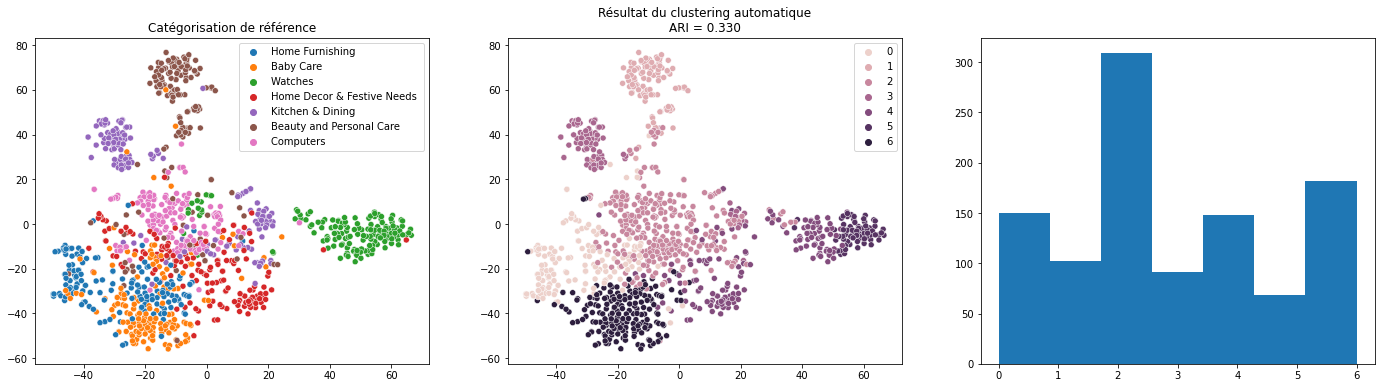

In [41]:
# Visualisation sur tsne
visu_resultats(features=feat_pca_vgg16_2,
               y_pred=y_pred_vgg16_2, ARI=ARI_vgg16_2)



Correspondance des clusters :  [4 1 2 5 3 6 0]
              precision    recall  f1-score   support

           0       0.56      0.68      0.61       150
           1       0.96      0.65      0.78       150
           2       0.45      0.92      0.60       150
           3       0.46      0.45      0.46       150
           4       0.46      0.46      0.46       150
           5       0.99      0.60      0.75       150
           6       0.99      0.45      0.61       150

    accuracy                           0.60      1050
   macro avg       0.69      0.60      0.61      1050
weighted avg       0.69      0.60      0.61      1050



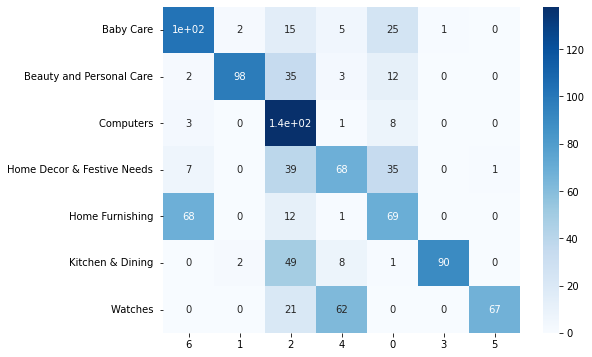

In [42]:
erreur_attribution(y_true=labels_int, y_pred=y_pred_vgg16_2)


## ResNet

In [43]:
my_resnet = ResNet50()

my_resnet.summary()



Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [44]:
# load model
model = ResNet50()

image_features_resnet = feature_extraction(
    model=model, data=data, path=path, preprocess_input=resnet_preprocess_input)



100%|██████████| 1050/1050 [02:47<00:00,  6.26it/s]


In [45]:
# calcul 7 categories (kmeans)
y_pred_resnet, ARI_resnet = clustering_7classes(
    X=image_features_resnet, labels=labels)



ARI : 0.45


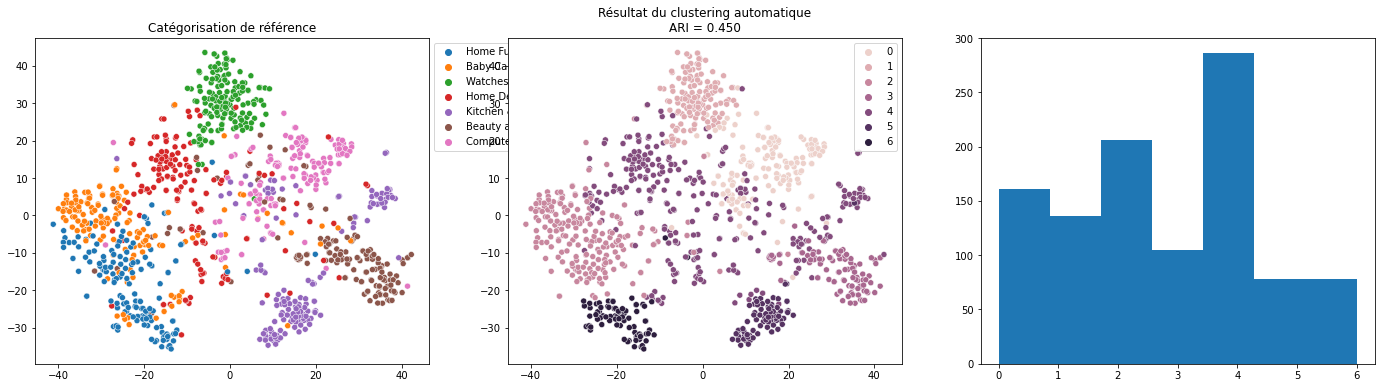

In [46]:
# Visualisation sur tsne
visu_resultats(features=image_features_resnet,
               y_pred=y_pred_resnet, ARI=ARI_resnet)



Correspondance des clusters :  [2 6 0 1 3 5 4]
              precision    recall  f1-score   support

           0       0.50      0.68      0.57       150
           1       0.95      0.67      0.78       150
           2       0.77      0.83      0.80       150
           3       0.45      0.87      0.60       150
           4       0.78      0.41      0.54       150
           5       0.99      0.51      0.68       150
           6       0.99      0.89      0.94       150

    accuracy                           0.69      1050
   macro avg       0.78      0.69      0.70      1050
weighted avg       0.78      0.69      0.70      1050



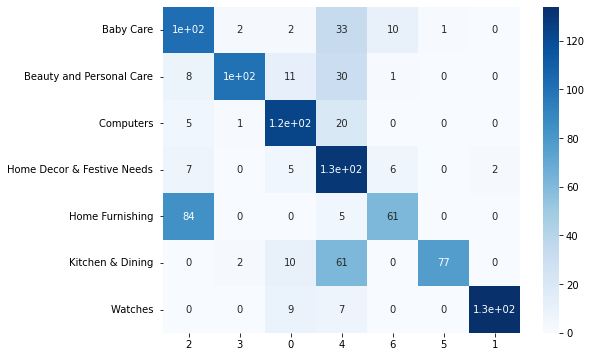

In [47]:
erreur_attribution(y_true=labels_int, y_pred=y_pred_resnet)


Réduction de dimension
ACP
Dimensions dataset avant réduction PCA :  (1050, 2048)
Dimensions dataset après réduction PCA :  (1050, 722)
ARI : 0.45


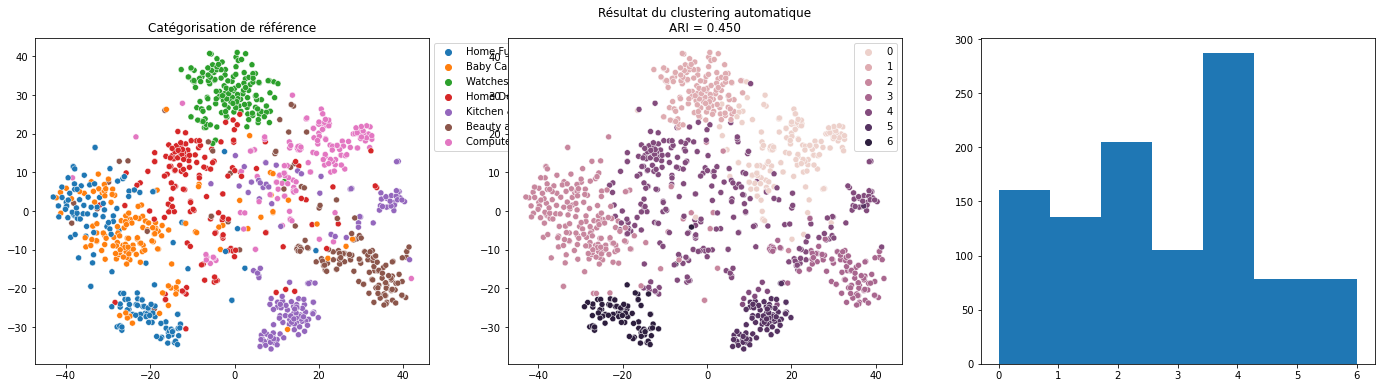

In [48]:
# Réduction de dimension
feat_pca_resnet = reduction_dimension(X=image_features_resnet)

# Classification finale
y_pred_resnet, ARI_resnet = clustering_7classes(
    X=feat_pca_resnet, labels=labels)

# Visualisation sur tsne
visu_resultats(features=feat_pca_resnet, y_pred=y_pred_resnet, ARI=ARI_resnet)



Correspondance des clusters :  [2 6 0 1 3 5 4]
              precision    recall  f1-score   support

           0       0.50      0.68      0.57       150
           1       0.95      0.67      0.78       150
           2       0.77      0.83      0.80       150
           3       0.45      0.87      0.59       150
           4       0.78      0.41      0.54       150
           5       0.99      0.51      0.68       150
           6       0.99      0.89      0.94       150

    accuracy                           0.69      1050
   macro avg       0.78      0.69      0.70      1050
weighted avg       0.78      0.69      0.70      1050



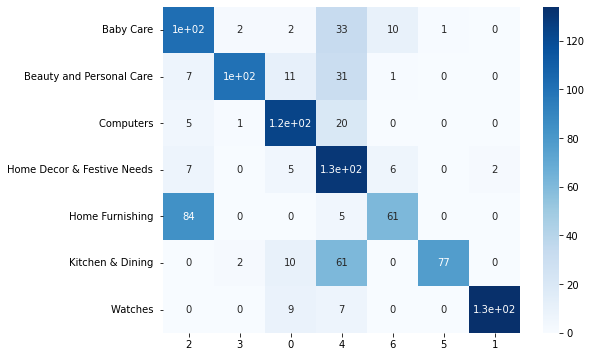

In [49]:
erreur_attribution(y_true=labels_int, y_pred=y_pred_resnet)


   ## EfficientNet

In [50]:
model = EfficientNetB0(include_top=False, weights='imagenet', pooling='avg')
model.summary()



Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, None, None, 3 0           input_6[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, None, None, 3 7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization[0][0]              
_____________________________________________________________________________________

In [51]:
compteur = 0
image_features_efficientnet = np.empty(shape=(0, 1280))
for img in tqdm(data.image):
    filename = path + img
    image = load_img(filename, target_size=(224, 224))
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    # reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # prepare the image for the VGG model
    image = efficientnet_preprocess_input(image)
    # get extracted features
    img_features = model(image)
    image_features_efficientnet = np.concatenate(
        (image_features_efficientnet, img_features), axis=0)
    compteur += 1



100%|██████████| 1050/1050 [02:08<00:00,  8.18it/s]


ARI : 0.49


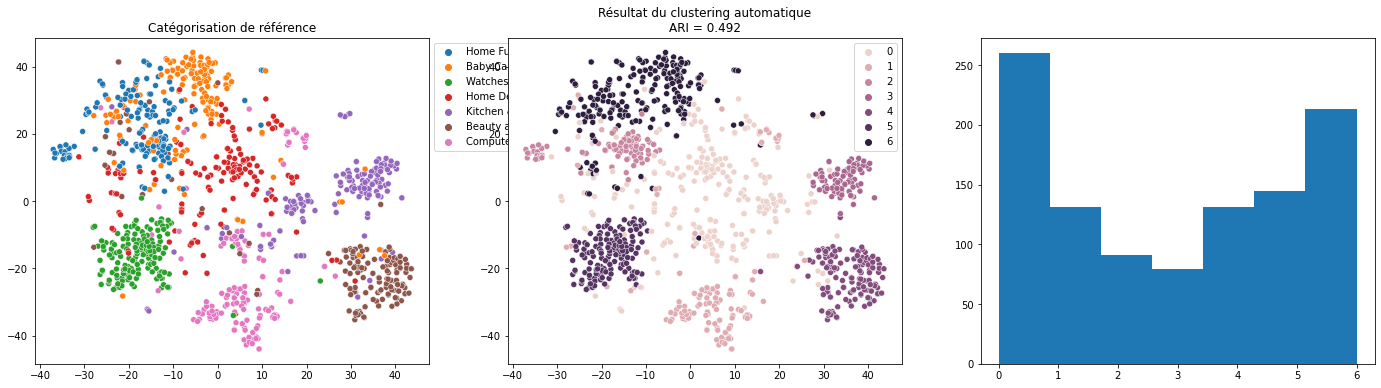

In [52]:
# calcul 7 categories (kmeans)
y_pred_efficientnet, ARI_efficientnet = clustering_7classes(
    X=image_features_efficientnet, labels=labels)

# Visualisation sur tsne
visu_resultats(features=image_features_efficientnet,
               y_pred=y_pred_efficientnet, ARI=ARI_efficientnet)



Correspondance des clusters :  [3 2 4 5 1 6 0]
              precision    recall  f1-score   support

           0       0.53      0.75      0.62       150
           1       0.91      0.79      0.85       150
           2       0.85      0.75      0.80       150
           3       0.48      0.83      0.61       150
           4       0.76      0.46      0.57       150
           5       0.97      0.51      0.67       150
           6       0.97      0.94      0.96       150

    accuracy                           0.72      1050
   macro avg       0.78      0.72      0.73      1050
weighted avg       0.78      0.72      0.73      1050



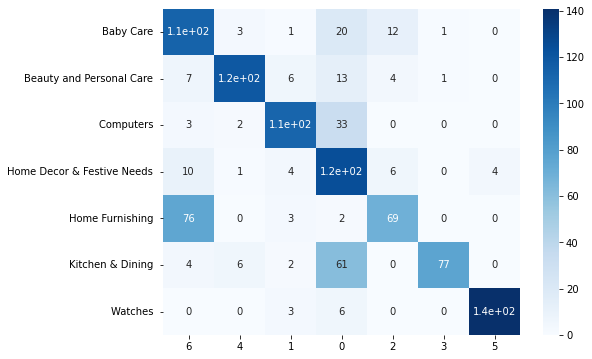

In [53]:
erreur_attribution(y_true=labels_int, y_pred=y_pred_efficientnet)


Réduction de dimension
ACP
Dimensions dataset avant réduction PCA :  (1050, 1280)
Dimensions dataset après réduction PCA :  (1050, 683)
ARI : 0.50


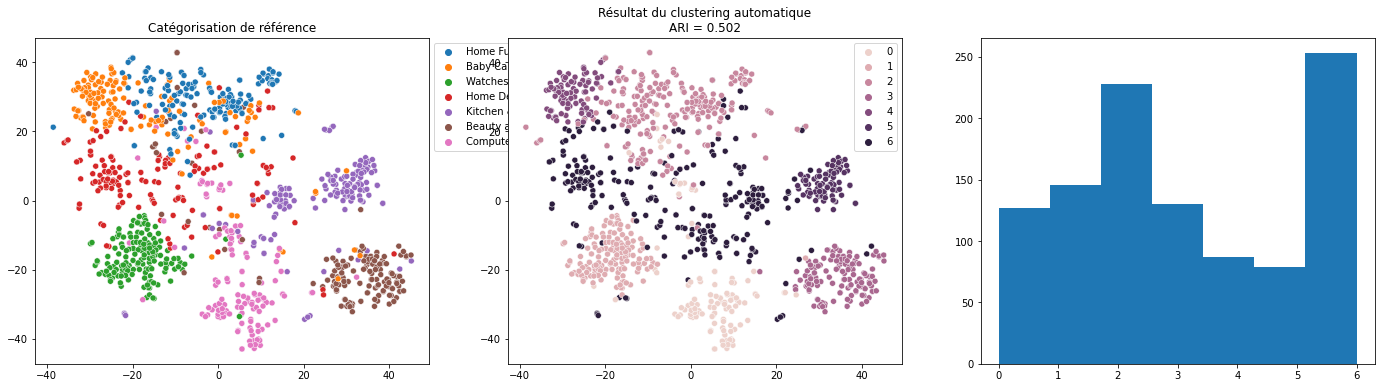

In [54]:
# Réduction de dimension
feat_pca_efficientnet = reduction_dimension(X=image_features_efficientnet)

# Classification finale
y_pred_efficientnet, ARI_efficientnet = clustering_7classes(
    X=feat_pca_efficientnet, labels=labels)

# Visualisation sur tsne
visu_resultats(features=feat_pca_efficientnet,
               y_pred=y_pred_efficientnet, ARI=ARI_efficientnet)



Correspondance des clusters :  [2 6 4 1 0 5 3]
              precision    recall  f1-score   support

           0       0.91      0.53      0.67       150
           1       0.92      0.79      0.85       150
           2       0.88      0.75      0.81       150
           3       0.45      0.77      0.57       150
           4       0.60      0.91      0.72       150
           5       0.97      0.51      0.67       150
           6       0.97      0.94      0.95       150

    accuracy                           0.74      1050
   macro avg       0.81      0.74      0.75      1050
weighted avg       0.81      0.74      0.75      1050



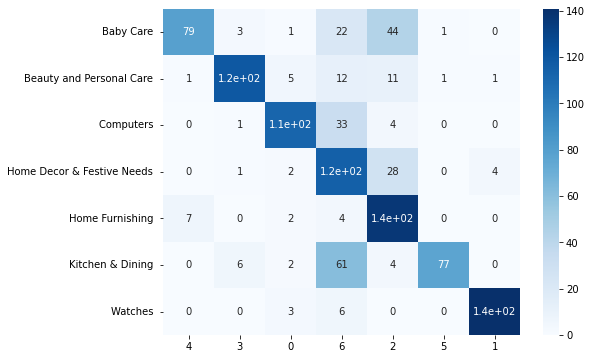

In [55]:
erreur_attribution(y_true=labels_int, y_pred=y_pred_efficientnet)


   # Utilisation du classifieur pré-entrainé
   pas d'entrainement spécifique, je fait l'hypothèse que le modèle pré-entrainé va trouver ce que représentent les images

   Le risque est de se retrouver avec trop de catégories.

   ## VGG16
   ### Test sur une image

In [56]:
# load an image from file
filename = path + list_photos[1]
image = load_img(filename, target_size=(224, 224))
# convert the image pixels to a numpy array
image = img_to_array(image)
# reshape data for the model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# prepare the image for the VGG model
image = vgg16_preprocess_input(image)



In [57]:
# Chargement du modèle
model = VGG16()



In [58]:
# prediction des probablités pour chaque classe prédéfinie (1000)
proba = model.predict(image)
proba



array([[4.21531070e-07, 3.04193037e-07, 3.34225803e-07, 7.19440493e-07,
        1.01092860e-06, 8.03036382e-05, 1.28404594e-07, 1.46060358e-07,
        3.28746154e-07, 1.94083941e-06, 8.81577762e-07, 8.21360402e-07,
        5.98388397e-07, 4.57659962e-06, 2.37440489e-07, 3.26778490e-07,
        5.99549708e-07, 1.41973987e-06, 4.59814146e-06, 3.43932606e-06,
        4.54128923e-07, 1.56157091e-06, 4.94491076e-07, 4.73480213e-07,
        1.12949988e-06, 2.43126152e-07, 7.77672469e-08, 2.67015480e-07,
        5.32342540e-07, 2.12757470e-07, 7.52562315e-08, 3.26498451e-07,
        1.31433137e-06, 2.00308705e-07, 2.35821221e-06, 2.04755594e-07,
        5.29613146e-07, 4.09740117e-08, 4.07114067e-06, 5.24003134e-08,
        3.07384823e-07, 2.16763667e-07, 5.51974040e-07, 1.20187167e-06,
        1.25571574e-07, 5.31782860e-07, 8.77113422e-08, 2.62747608e-06,
        1.84107183e-08, 7.25613614e-09, 4.01074587e-08, 5.94830999e-06,
        1.24528797e-05, 1.66047503e-05, 6.74102807e-07, 2.440235

In [59]:
# conversion des probabilités en label
label_pred = decode_predictions(proba)
label_pred



[[('n03314780', 'face_powder', 0.26026782),
  ('n03400231', 'frying_pan', 0.24341343),
  ('n04270147', 'spatula', 0.07198678),
  ('n04019541', 'puck', 0.052658815),
  ('n04596742', 'wok', 0.042355023)]]

In [60]:
# récupération du résultat le plus probable
label_pred = label_pred[0][0]
label_pred



('n03314780', 'face_powder', 0.26026782)

In [61]:
label_pred[1]



'face_powder'

In [62]:
# affichage du resultat
print('%s (%.2f%%)' % (label_pred[1], label_pred[2]*100))



face_powder (26.03%)


   ### Pour toutes les images

In [63]:
compteur = 0
label_pred_vgg16 = []
for img in tqdm(data.image):
    filename = path + img
    image = load_img(filename, target_size=(224, 224))
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    # reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # prepare the image for the VGG model
    image = vgg16_preprocess_input(image)
    # predict the probability across all output classes
    proba = model.predict(image)
    # convert the probabilities to class labels
    label = decode_predictions(proba)
    # retrieve the most likely result, e.g. highest probability
    label = label[0][0][1]
    label_pred_vgg16.append(label)
    compteur += 1



100%|██████████| 1050/1050 [04:14<00:00,  4.13it/s]


In [64]:
pd.DataFrame(label_pred_vgg16)[0].value_counts()



coffee_mug          76
magnetic_compass    47
modem               32
analog_clock        32
lotion              28
                    ..
folding_chair        1
tractor              1
laptop               1
ballpoint            1
washbasin            1
Name: 0, Length: 239, dtype: int64

   #### Calcul ARI

In [65]:
print("ARI : {:.2f}".format(
    adjusted_rand_score(labels, label_pred_vgg16)))



ARI : 0.15


   Génère trop de catégories. Il faut le contraindre à créer uniquement 7 catégories.

   # CNN avec entrainement uniquement du classifieur

   ## Tri des images pour permettre l'apprentissage
   Il faut que chaque image soit dans un dossier qui correspond à son label

   Puis il faudra splitter le jeu de données en train/val/test

In [66]:
data.label.unique()



array(['Home Furnishing ', 'Baby Care ', 'Watches ',
       'Home Decor & Festive Needs ', 'Kitchen & Dining ',
       'Beauty and Personal Care ', 'Computers '], dtype=object)

In [67]:
# DOSSIER CREE UNE FOIS, PAS BESOIN DE LE REFAIRE

# # creation du dossier images_sorted qui contient toutes les images triées par catégories
# parent = 'C:/Users/Helene/Documents/03_DataScience/02_FORMATION/OpenClassRooms/01_PROJETS/P6/01_DATA/Flipkart/'
# dossier = 'Images_sorted'
# chemin = parent + dossier

# os.mkdir(chemin)



In [68]:
# DEJA FAIT UNE FOIS, PAS BESOIN DE LE REFAIRE

# # Attribution des images à chaque catégorie
# racine = 'C:/Users/Helene/Documents/03_DataScience/02_FORMATION/OpenClassRooms/01_PROJETS/P6/01_DATA/Flipkart/Images_sorted'
# for i in tqdm(range(data.shape[0])):
#     # image qu'il va falloir copier
#     img = data.image[i]
#     source = path + img
#     # creation du dossier cible si il n'existe pas
#     dossier = data.label[i]
#     # retrait de l'espace systématiquement present à la fin de la str
#     dossier = dossier[:-1]
#     chemin = racine + '/' + dossier
#     os.makedirs(chemin, exist_ok=True)
#     destination = chemin + '/' + img
#     # copie de l'image vers le dossier
#     shutil.copyfile(source, destination)



   Création des dossiers train / test / val

In [69]:
input_folder = 'C:/Users/Helene/Documents/03_DataScience/02_FORMATION/OpenClassRooms/01_PROJETS/P6/01_DATA/Flipkart/Images_sorted'
input_folder



'C:/Users/Helene/Documents/03_DataScience/02_FORMATION/OpenClassRooms/01_PROJETS/P6/01_DATA/Flipkart/Images_sorted'

In [70]:
output = "C:/Users/Helene/Documents/03_DataScience/02_FORMATION/OpenClassRooms/01_PROJETS/P6/01_DATA/Flipkart/Split"
splitfolders.ratio(input_folder, output=output, seed=42, ratio=(.8, .1, .1))



Copying files: 1050 files [00:02, 402.07 files/s]


   ## Chargement des données

In [71]:
racine = 'C:/Users/Helene/Documents/03_DataScience/02_FORMATION/OpenClassRooms/01_PROJETS/P6/01_DATA/Flipkart/Split/train'
classes = os.listdir(racine)
classes



['Baby Care',
 'Beauty and Personal Care',
 'Computers',
 'Home Decor & Festive Needs',
 'Home Furnishing',
 'Kitchen & Dining',
 'Watches']

In [72]:
train_data_dir = 'C:/Users/Helene/Documents/03_DataScience/02_FORMATION/OpenClassRooms/01_PROJETS/P6/01_DATA/Flipkart/Split/train'
val_data_dir = 'C:/Users/Helene/Documents/03_DataScience/02_FORMATION/OpenClassRooms/01_PROJETS/P6/01_DATA/Flipkart/Split/val'
test_data_dir = 'C:/Users/Helene/Documents/03_DataScience/02_FORMATION/OpenClassRooms/01_PROJETS/P6/01_DATA/Flipkart/Split/test'

batch_size = 10



In [73]:
# données d'entrainement
train_dataset = image_dataset_from_directory(directory=train_data_dir, labels='inferred', label_mode='categorical',
                                             class_names=classes, image_size=(224, 224), seed=0, batch_size=batch_size)

# Données de validation
val_dataset = image_dataset_from_directory(directory=val_data_dir, labels='inferred', label_mode='categorical',
                                           class_names=classes, image_size=(224, 224), seed=0, batch_size=batch_size)

# Données de test
test_dataset = image_dataset_from_directory(directory=test_data_dir, labels='inferred', label_mode='categorical',
                                            class_names=classes, image_size=(224, 224), seed=0, batch_size=batch_size)



Found 840 files belonging to 7 classes.
Found 105 files belonging to 7 classes.
Found 105 files belonging to 7 classes.


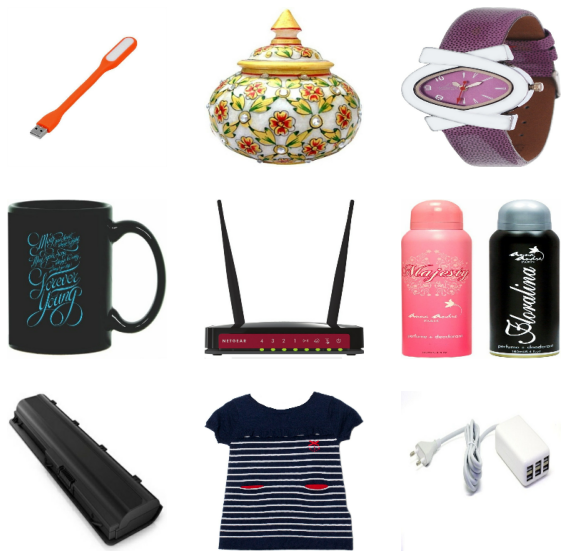

In [74]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, label in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        # plt.title(class_names[label[i]])
        plt.axis("off")



In [75]:
print('Number of validation batches: %d' %
      tf.data.experimental.cardinality(val_dataset))
print('Number of test batches: %d' %
      tf.data.experimental.cardinality(test_dataset))
print('Number of train batches: %d' %
      tf.data.experimental.cardinality(train_dataset))



Number of validation batches: 11
Number of test batches: 11
Number of train batches: 84


  ## Construction du modèle

In [76]:
# Chargement VGG-16 pré-entraîné sur ImageNet et sans les couches fully-connected
base_model = VGG16(weights="imagenet", include_top=False,
                   input_shape=(224, 224, 3))
base_model.summary()



Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [77]:
# le modèle de base n'a pas à être ré-entrainé
base_model.trainable = False



  ### Data augmentation
  comme le jeu de données est petit, cela permet de multiplier les images en leur apportant de légères modifications (rotations, retournement horizontal)

  ==> permet de prévenir l'overfitting

In [78]:
data_augmentation = tf.keras.Sequential([
    RandomFlip('horizontal'),
    RandomRotation(0.2),
])


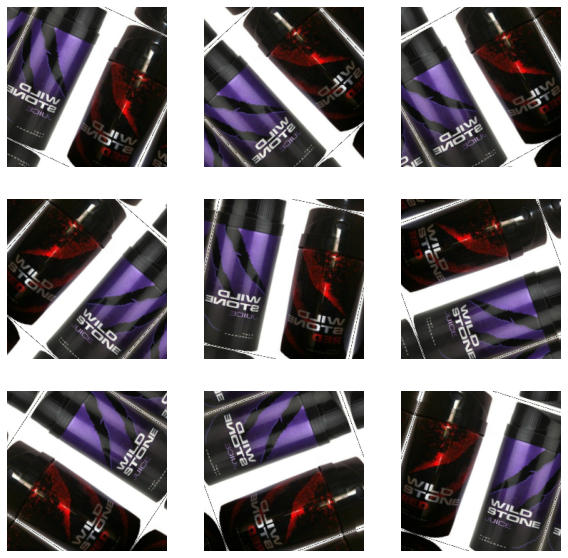

In [79]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[1]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')


In [80]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = vgg16_preprocess_input(inputs)
x = base_model(x, training=False)
# Ajout nouvelle couche fully-connected pour la classification à 7 classes

flat1 = Flatten()(x)
class1 = Dense(1024, activation='relu')(flat1)
predictions = Dense(7, activation='softmax')(class1)

new_model = Model(inputs=inputs, outputs=predictions)



In [81]:
# Compilation du modèle
new_model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(
    learning_rate=0.001), metrics=["accuracy"])

# callback
callback = EarlyStopping(monitor='val_loss', patience=3)

In [82]:
new_model.summary()



Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf_op_layer_BiasAdd (TensorF [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              25691136  
_________________________________________________________________
dense_1 (Dense)              (None, 7)                

In [83]:
len(new_model.trainable_variables)



4

  ## Entrainement du modèle

In [84]:
initial_epochs = 10

history = new_model.fit(train_dataset,
                        epochs=initial_epochs,
                        validation_data=val_dataset,
                        callbacks=[callback])



Epoch 1/10
84/84 [==============================] - 157s 2s/step - loss: 30.8238 - accuracy: 0.6917 - val_loss: 6.4576 - val_accuracy: 0.8190
Epoch 2/10
84/84 [==============================] - 150s 2s/step - loss: 1.8505 - accuracy: 0.9250 - val_loss: 5.1512 - val_accuracy: 0.8381
Epoch 3/10
84/84 [==============================] - 152s 2s/step - loss: 0.3851 - accuracy: 0.9762 - val_loss: 5.9965 - val_accuracy: 0.8000
Epoch 4/10
84/84 [==============================] - 150s 2s/step - loss: 0.1461 - accuracy: 0.9893 - val_loss: 5.7370 - val_accuracy: 0.8095
Epoch 5/10
84/84 [==============================] - 150s 2s/step - loss: 0.0677 - accuracy: 0.9952 - val_loss: 5.6657 - val_accuracy: 0.8000


  ## Résultats

In [85]:
loss0, accuracy0 = new_model.evaluate(val_dataset)



11/11 [==============================] - 14s 1s/step - loss: 5.6657 - accuracy: 0.8000


In [86]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))



initial loss: 5.67
initial accuracy: 0.80


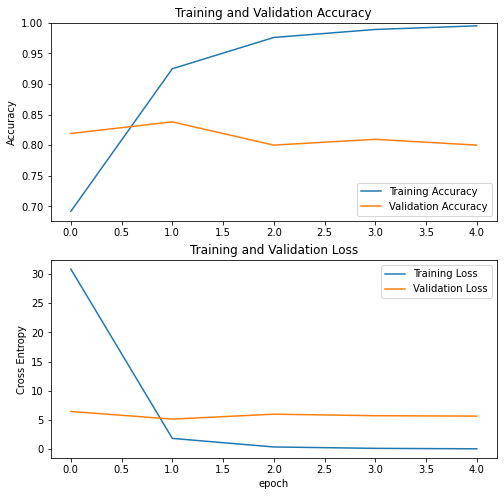

In [87]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()



In [88]:
loss_test, accuracy_test = new_model.evaluate(test_dataset)
print("test loss: {:.2f}".format(loss_test))
print("test accuracy: {:.2f}".format(accuracy_test))



11/11 [==============================] - 14s 1s/step - loss: 9.5331 - accuracy: 0.8000
test loss: 9.53
test accuracy: 0.80


  ## Feature extraction et ARI

100%|██████████| 1050/1050 [04:00<00:00,  4.37it/s]


ARI : 0.35


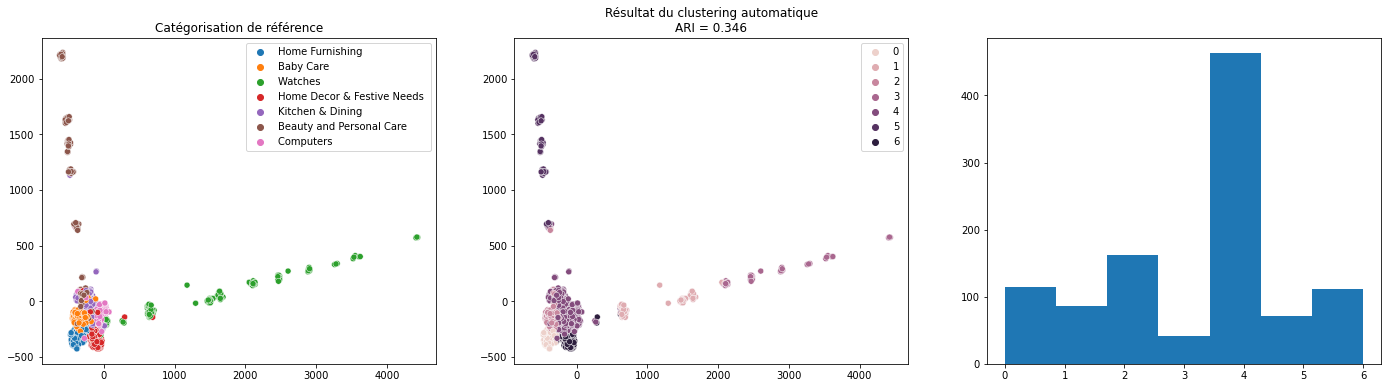

In [89]:
# Feature extraction
image_features_new_model = feature_extraction(
    model=new_model, data=data, path=path, preprocess_input=vgg16_preprocess_input)

# calcul 7 categories (kmeans)
y_pred_new_model, ARI_new_model = clustering_7classes(
    X=image_features_new_model, labels=labels)

# Visualisation sur tsne
visu_resultats(features=image_features_new_model,
               y_pred=y_pred_new_model, ARI=ARI_new_model)


Correspondance des clusters :  [4 6 0 6 5 1 3]
              precision    recall  f1-score   support

           0       0.75      0.81      0.78       150
           1       0.99      0.47      0.63       150
           2       0.00      0.00      0.00       150
           3       0.89      0.67      0.76       150
           4       0.97      0.74      0.84       150
           5       0.32      0.99      0.48       150
           6       0.99      0.84      0.91       150

    accuracy                           0.64      1050
   macro avg       0.70      0.64      0.63      1050
weighted avg       0.70      0.64      0.63      1050



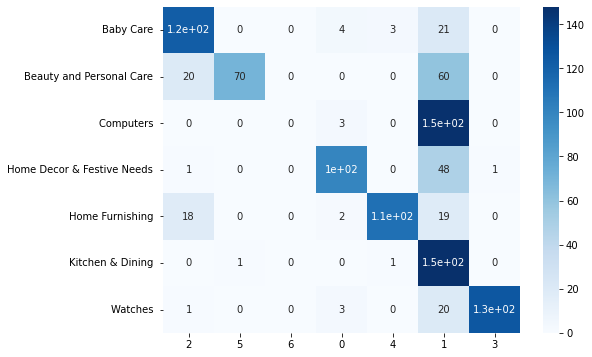

In [90]:
erreur_attribution(y_true=labels_int, y_pred=y_pred_new_model)


Réduction de dimension
ACP
Dimensions dataset avant réduction PCA :  (1050, 1024)
Dimensions dataset après réduction PCA :  (1050, 202)
ARI : 0.37


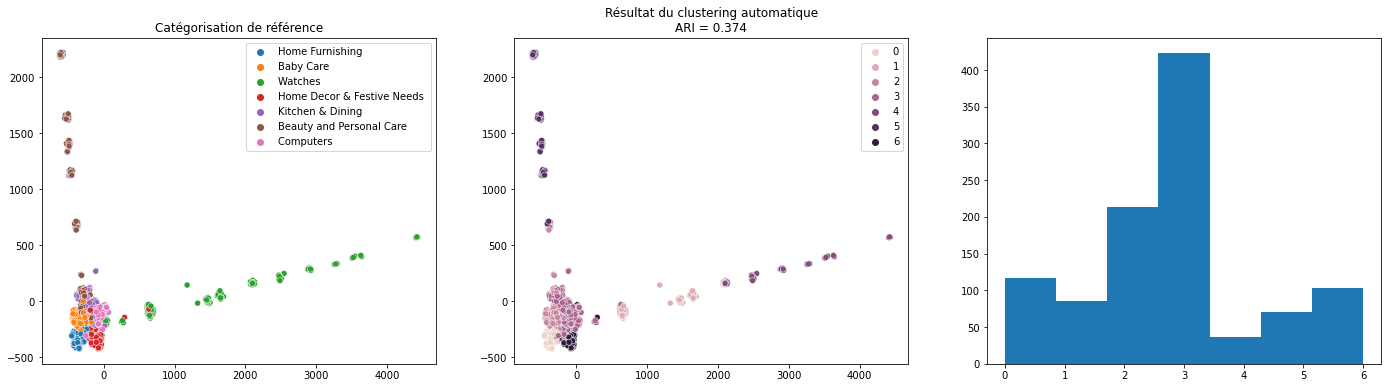

In [91]:
# Réduction de dimension
feat_pca_new_model = reduction_dimension(X=image_features_new_model)

# Classification finale
y_pred_new_model, ARI_new_model = clustering_7classes(
    X=feat_pca_new_model, labels=labels)

# Visualisation sur tsne
visu_resultats(feat_pca_new_model, y_pred=y_pred_new_model, ARI=ARI_new_model)



Correspondance des clusters :  [4 6 0 5 6 1 3]
              precision    recall  f1-score   support

           0       0.61      0.87      0.72       150
           1       0.99      0.47      0.63       150
           2       0.00      0.00      0.00       150
           3       0.92      0.63      0.75       150
           4       0.95      0.74      0.83       150
           5       0.35      0.99      0.52       150
           6       0.99      0.81      0.89       150

    accuracy                           0.64      1050
   macro avg       0.69      0.64      0.62      1050
weighted avg       0.69      0.64      0.62      1050



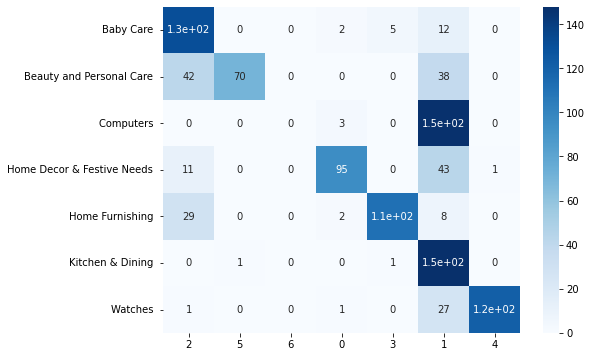

In [92]:
erreur_attribution(y_true=labels_int, y_pred=y_pred_new_model)


  # CNN avec apprentissage des couches supérieures du réseau pour pouvoir extraire les features
  objectif : modifier les couches supérieures de façon à pouvoir extraire des features qui soient plus représentatives des données disponibles et ainsi pouvoir les combiner avec les données texte

  ## Construction du modèle
  On repart sur le modèle précédent en libérant les couches du dernier bloc pour appronfondir l'apprentissage

In [93]:
base_model.trainable = True
print("Nombre de couches du base_model: ", len(base_model.layers))
base_model.summary()



Nombre de couches du base_model:  19
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2

In [94]:
# Fine-tune à partir de cette couche
fine_tune_at = 15
# Toutes les couches avant la fine_tune_at sont bloquées pour l'entrainement.
for layer in base_model.layers[:fine_tune_at]:
    print(layer)
    layer.trainable = False
print(base_model.summary())



Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [95]:
# Compilation du modèle
new_model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(
    learning_rate=0.001/10), metrics=["accuracy"])
new_model.summary()



Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf_op_layer_BiasAdd (TensorF [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              25691136  
_________________________________________________________________
dense_1 (Dense)              (None, 7)                

In [96]:
len(new_model.trainable_variables)



10

  ## Entrainement du modèle
  on part du modèle déjà entrainé avec les données

In [97]:
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = new_model.fit(train_dataset,
                             epochs=total_epochs,
                             initial_epoch=history.epoch[-1],
                             validation_data=val_dataset,
                             callbacks=[callback])



Epoch 5/20
84/84 [==============================] - 180s 2s/step - loss: 0.0041 - accuracy: 0.9988 - val_loss: 5.7459 - val_accuracy: 0.8000
Epoch 6/20
84/84 [==============================] - 178s 2s/step - loss: 2.4102e-06 - accuracy: 1.0000 - val_loss: 5.7458 - val_accuracy: 0.8000
Epoch 7/20
84/84 [==============================] - 178s 2s/step - loss: 2.2852e-06 - accuracy: 1.0000 - val_loss: 5.7457 - val_accuracy: 0.8000
Epoch 8/20
84/84 [==============================] - 179s 2s/step - loss: 2.1784e-06 - accuracy: 1.0000 - val_loss: 5.7457 - val_accuracy: 0.8000
Epoch 9/20
84/84 [==============================] - 180s 2s/step - loss: 2.0847e-06 - accuracy: 1.0000 - val_loss: 5.7456 - val_accuracy: 0.8000
Epoch 10/20
84/84 [==============================] - 179s 2s/step - loss: 2.0019e-06 - accuracy: 1.0000 - val_loss: 5.7454 - val_accuracy: 0.8000
Epoch 11/20
84/84 [==============================] - 179s 2s/step - loss: 1.9283e-06 - accuracy: 1.0000 - val_loss: 5.7454 - val_accu

  ## Résultats

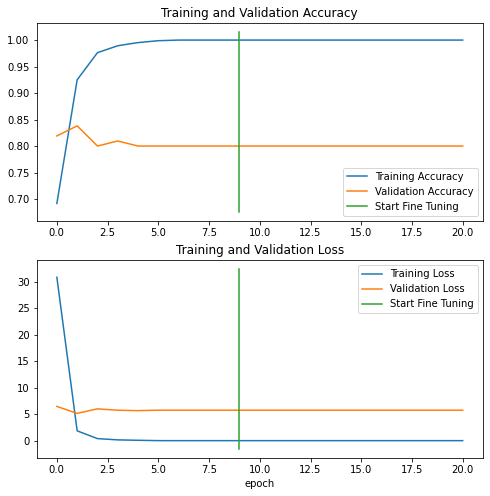

In [98]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
# plt.ylim([0.8, 1])
plt.plot([initial_epochs-1, initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
# plt.ylim([0, 1.0])
plt.plot([initial_epochs-1, initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()



In [99]:
loss_test, accuracy_test = new_model.evaluate(test_dataset)
print("test loss: {:.2f}".format(loss_test))
print("test accuracy: {:.2f}".format(accuracy_test))



11/11 [==============================] - 10s 888ms/step - loss: 9.4299 - accuracy: 0.8095
test loss: 9.43
test accuracy: 0.81


  Les résultats sont légèrement meilleurs si les couches supérieures sont laissées libre pour l'entrainement.

      ==> Besoin d'ajustement des paramètres ?
      ==> trop peu de données pour apprentissage plus poussé ?

  ## Feature extraction

In [100]:
new_model.summary()



Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf_op_layer_BiasAdd (TensorF [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              25691136  
_________________________________________________________________
dense_1 (Dense)              (None, 7)                

In [101]:
image_features_new_model_2 = feature_extraction(
    model=new_model, data=data, path=path, preprocess_input=vgg16_preprocess_input)



100%|██████████| 1050/1050 [03:49<00:00,  4.58it/s]


In [102]:
image_features_new_model_2.shape



(1050, 1024)

  ## Clustering et ARI

In [103]:
y_pred_new_model_2, ARI_new_model_2 = clustering_7classes(
    image_features_new_model_2, labels)



ARI : 0.35


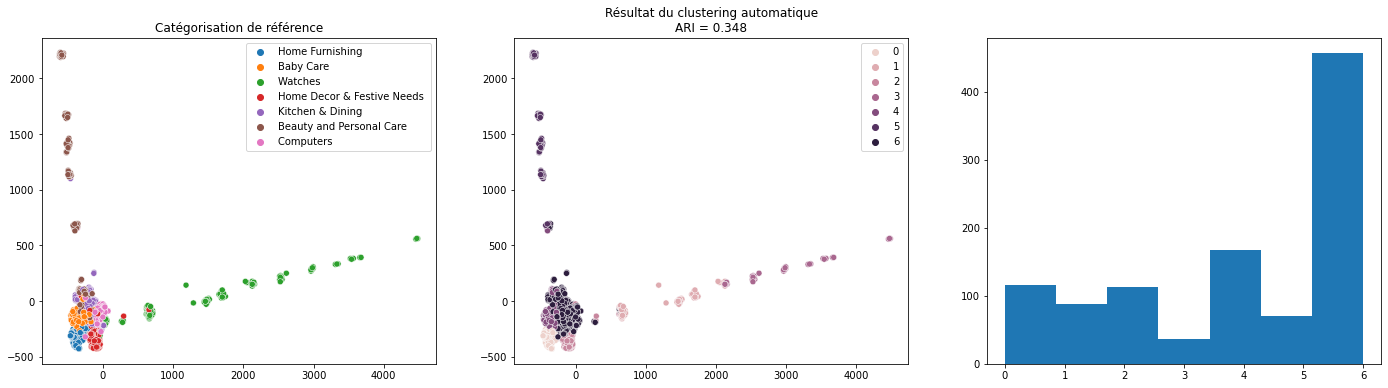

In [104]:
visu_resultats(image_features_new_model_2,
               y_pred=y_pred_new_model_2, ARI=ARI_new_model_2)



Correspondance des clusters :  [4 6 3 6 0 1 5]
              precision    recall  f1-score   support

           0       0.72      0.81      0.76       150
           1       0.99      0.47      0.63       150
           2       0.00      0.00      0.00       150
           3       0.88      0.67      0.76       150
           4       0.97      0.75      0.84       150
           5       0.32      0.99      0.49       150
           6       0.99      0.83      0.90       150

    accuracy                           0.64      1050
   macro avg       0.70      0.64      0.63      1050
weighted avg       0.70      0.64      0.63      1050



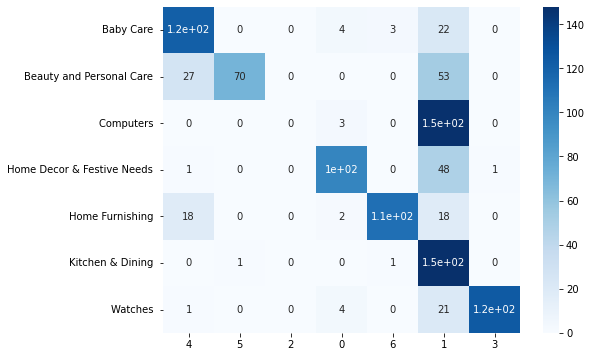

In [105]:
erreur_attribution(y_true=labels_int, y_pred=y_pred_new_model_2)


Réduction de dimension
ACP
Dimensions dataset avant réduction PCA :  (1050, 1024)
Dimensions dataset après réduction PCA :  (1050, 202)
ARI : 0.34


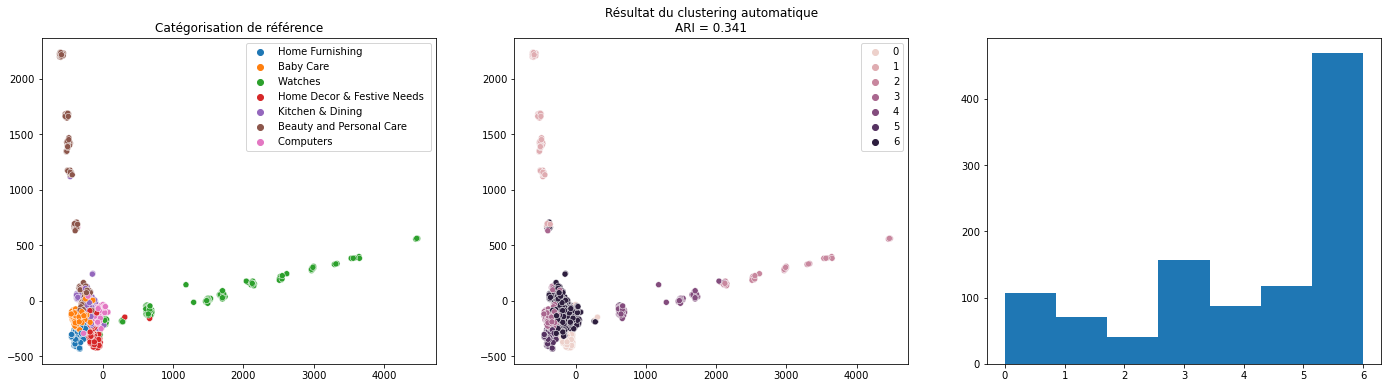

In [106]:
# Réduction de dimension
feat_pca_new_model_2 = reduction_dimension(image_features_new_model_2)

# Classification finale
y_pred_new_model_2, ARI_new_model_2 = clustering_7classes(
    feat_pca_new_model_2, labels)

# visualisation
visu_resultats(feat_pca_new_model_2,
               y_pred=y_pred_new_model_2, ARI=ARI_new_model_2)



Correspondance des clusters :  [3 1 6 0 6 4 5]
              precision    recall  f1-score   support

           0       0.76      0.80      0.78       150
           1       0.99      0.47      0.63       150
           2       0.00      0.00      0.00       150
           3       0.91      0.65      0.75       150
           4       0.97      0.75      0.85       150
           5       0.32      0.99      0.48       150
           6       0.99      0.85      0.92       150

    accuracy                           0.64      1050
   macro avg       0.70      0.64      0.63      1050
weighted avg       0.70      0.64      0.63      1050



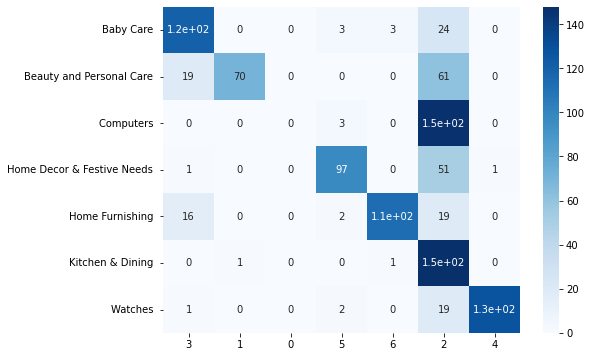

In [107]:
erreur_attribution(y_true=labels_int, y_pred=y_pred_new_model_2)


# TEST workflow avec EfficientNet
## Entrainement uniquement classifieur

In [176]:
# Chargement VGG-16 pré-entraîné sur ImageNet et sans les couches fully-connected
base_model_effnet = EfficientNetB0(weights="imagenet", include_top=False,
                   input_shape=(224, 224, 3))
# le modèle de base n'a pas à être ré-entrainé
base_model_effnet.trainable = False

base_model_effnet.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_7 (Rescaling)         (None, 224, 224, 3)  0           input_21[0][0]                   
__________________________________________________________________________________________________
normalization_7 (Normalization) (None, 224, 224, 3)  7           rescaling_7[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization_7[0][0]            
_____________________________________________________________________________________

In [177]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = efficientnet_preprocess_input(inputs)
x = base_model_effnet(x, training=False)
# Ajout nouvelle couche fully-connected pour la classification à 7 classes

flat1 = Flatten()(x)
class1 = Dense(1280, activation='relu')(flat1)
predictions = Dense(7, activation='softmax')(class1)

new_model_effnet = Model(inputs=inputs, outputs=predictions)

In [178]:
# Compilation du modèle
new_model_effnet.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(
    learning_rate=0.001), metrics=["accuracy"])

# callback
callback = EarlyStopping(monitor='val_loss', patience=3)

In [179]:
initial_epochs = 10

history_effnet = new_model_effnet.fit(train_dataset,
                        epochs=initial_epochs,
                        validation_data=val_dataset,
                        callbacks=[callback])

Epoch 1/10
84/84 [==============================] - 66s 784ms/step - loss: 5.9458 - accuracy: 0.7357 - val_loss: 1.5508 - val_accuracy: 0.7619
Epoch 2/10
84/84 [==============================] - 65s 769ms/step - loss: 0.3709 - accuracy: 0.9393 - val_loss: 1.0577 - val_accuracy: 0.8381
Epoch 3/10
84/84 [==============================] - 65s 774ms/step - loss: 0.1024 - accuracy: 0.9821 - val_loss: 0.7770 - val_accuracy: 0.8571
Epoch 4/10
84/84 [==============================] - 66s 781ms/step - loss: 0.0929 - accuracy: 0.9929 - val_loss: 0.8852 - val_accuracy: 0.8857
Epoch 5/10
84/84 [==============================] - 66s 788ms/step - loss: 0.0018 - accuracy: 0.9988 - val_loss: 0.8059 - val_accuracy: 0.8762
Epoch 6/10
84/84 [==============================] - 67s 792ms/step - loss: 2.4150e-04 - accuracy: 1.0000 - val_loss: 0.8031 - val_accuracy: 0.8762


### Résultats

In [180]:
loss0, accuracy0 = new_model_effnet.evaluate(val_dataset)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

loss_test, accuracy_test = new_model_effnet.evaluate(test_dataset)
print("test loss: {:.2f}".format(loss_test))
print("test accuracy: {:.2f}".format(accuracy_test))

11/11 [==============================] - 4s 340ms/step - loss: 0.8031 - accuracy: 0.8762
initial loss: 0.80
initial accuracy: 0.88
11/11 [==============================] - 4s 374ms/step - loss: 2.0530 - accuracy: 0.7810
test loss: 2.05
test accuracy: 0.78


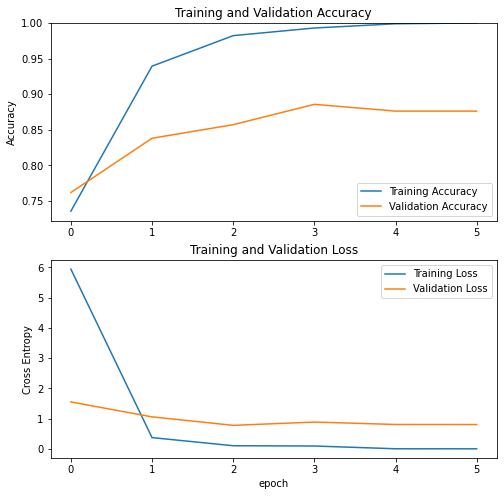

In [181]:
acc = history_effnet.history['accuracy']
val_acc = history_effnet.history['val_accuracy']

loss = history_effnet.history['loss']
val_loss = history_effnet.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()



### Feature extraction

100%|██████████| 1050/1050 [03:17<00:00,  5.30it/s]


ARI : 0.38
Correspondance des clusters :  [5 2 6 2 1 4 0]
              precision    recall  f1-score   support

           0       0.67      0.01      0.03       150
           1       1.00      0.54      0.70       150
           2       0.91      0.49      0.63       150
           3       0.00      0.00      0.00       150
           4       0.50      0.99      0.67       150
           5       0.33      0.99      0.49       150
           6       1.00      0.91      0.95       150

    accuracy                           0.56      1050
   macro avg       0.63      0.56      0.50      1050
weighted avg       0.63      0.56      0.50      1050



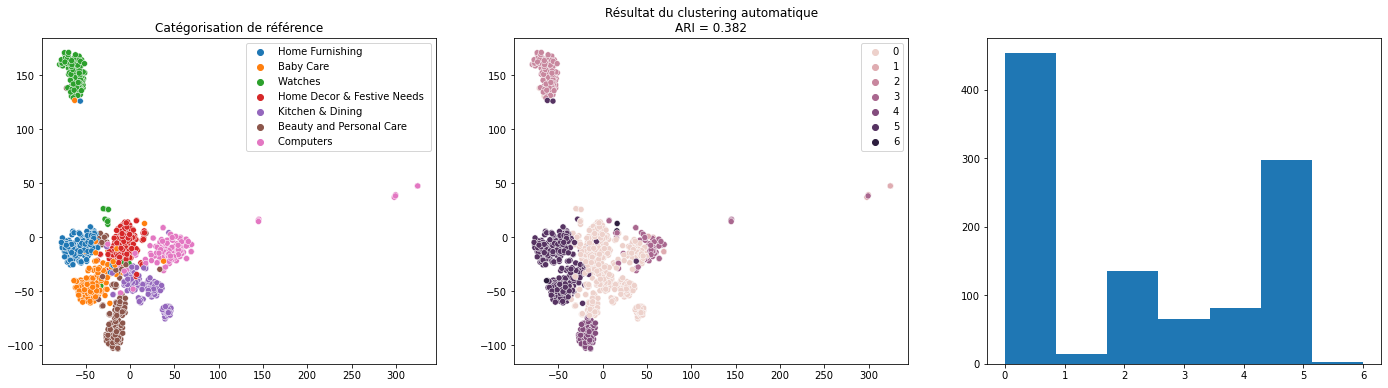

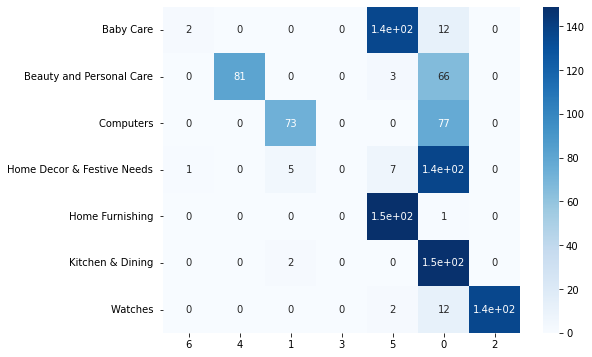

In [182]:
# Feature extraction
image_features_new_model_effnet = feature_extraction(
    model=new_model_effnet, data=data, path=path, preprocess_input=efficientnet_preprocess_input)

# calcul 7 categories (kmeans)
y_pred_new_model_effnet, ARI_new_model_effnet = clustering_7classes(
    X=image_features_new_model_effnet, labels=labels)

# Visualisation sur tsne
visu_resultats(features=image_features_new_model_effnet,
               y_pred=y_pred_new_model_effnet, ARI=ARI_new_model_effnet)

erreur_attribution(y_true=labels_int, y_pred=y_pred_new_model_effnet)

[[ 12   0   0   0   0 136   2]
 [ 66   0   0   0  81   3   0]
 [ 77  15   0  58   0   0   0]
 [137   0   0   5   0   7   1]
 [  1   0   0   0   0 149   0]
 [148   0   0   2   0   0   0]
 [ 12   0 136   0   0   2   0]]
<class 'numpy.ndarray'>
Correspondance des clusters :  [5 3 6 2 1 4 0]
              precision    recall  f1-score   support

           0       0.67      0.01      0.03       150
           1       1.00      0.54      0.70       150
           2       0.89      0.39      0.54       150
           3       0.00      0.00      0.00       150
           4       0.50      0.99      0.67       150
           5       0.33      0.99      0.49       150
           6       1.00      0.91      0.95       150

    accuracy                           0.55      1050
   macro avg       0.63      0.55      0.48      1050
weighted avg       0.63      0.55      0.48      1050



<AxesSubplot:>

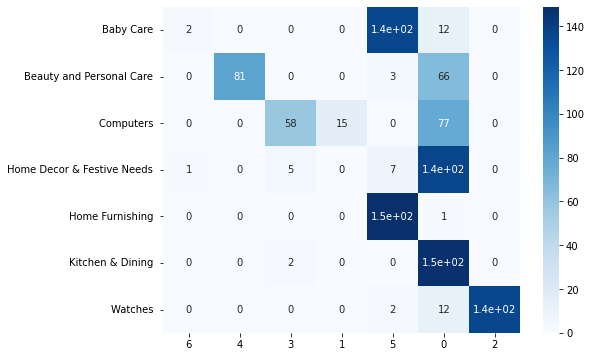

In [186]:

# Calcul de la matrice de confusion
conf_mat = confusion_matrix(y_true=labels_int, y_pred=y_pred_new_model_effnet)
print(conf_mat)
# Alignement le long de la diagonale
# corresp = np.argmax(conf_mat, axis=0)
corresp = np.array([5, 3,6,2,1,4,0])
print(type(corresp))
print("Correspondance des clusters : ", corresp)
labels_df = pd.Series(labels, name="labels").to_frame()
labels_df['y_true'] = labels_int
labels_df['y_pred'] = y_pred_new_model_effnet
labels_df['y_pred_transform'] = labels_df['y_pred'].apply(
    lambda x: corresp[x])
# re-calcul de la nouvelle matrice de confusion
conf_mat = confusion_matrix(labels_int, labels_df.y_pred_transform)
print(classification_report(labels_int, labels_df.y_pred_transform))
# visu
corresp = pd.DataFrame(corresp, columns=['corresp'])
corresp = corresp.sort_values(by='corresp', axis=0)
index = list(corresp.index)
df_cm = pd.DataFrame(conf_mat, index=[label for label in list_labels],
                        columns=[i for i in index])
plt.figure(figsize=(8, 6))
sns.heatmap(df_cm, annot=True, cmap="Blues")


Réduction de dimension
ACP
Dimensions dataset avant réduction PCA :  (1050, 1280)
Dimensions dataset après réduction PCA :  (1050, 309)
ARI : 0.21
Correspondance des clusters :  [5 3 4 6 2 1 2]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       150
           1       1.00      0.69      0.81       150
           2       0.97      0.23      0.37       150
           3       0.73      0.05      0.10       150
           4       0.22      0.99      0.37       150
           5       0.98      0.70      0.82       150
           6       1.00      0.87      0.93       150

    accuracy                           0.50      1050
   macro avg       0.70      0.50      0.49      1050
weighted avg       0.70      0.50      0.49      1050



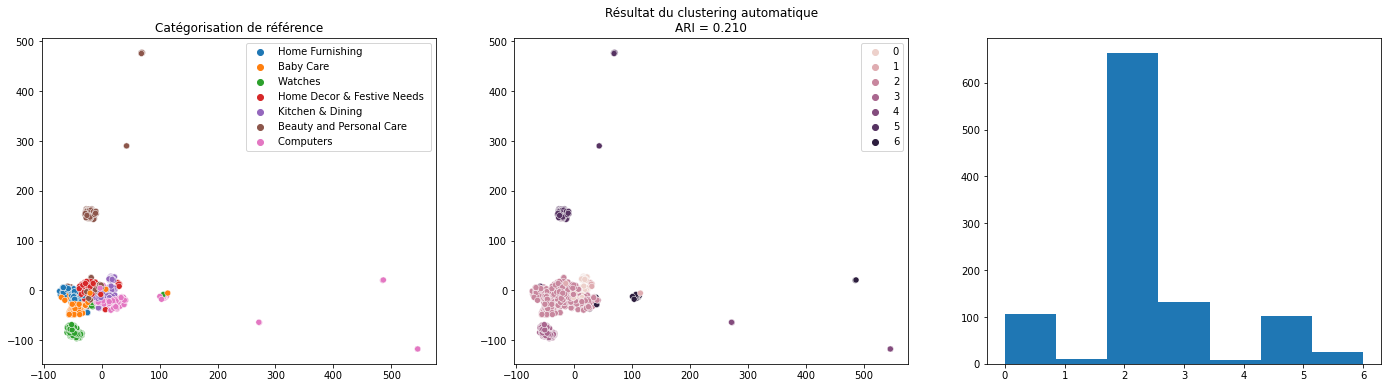

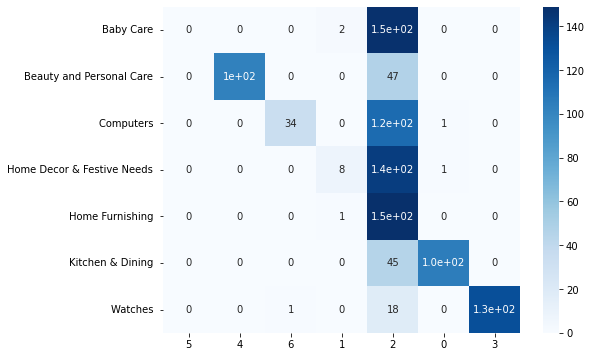

In [145]:
# Réduction de dimension
feat_pca_new_model_effnet = reduction_dimension(X=image_features_new_model_effnet)

# Classification finale
y_pred_new_model_effnet, ARI_new_model_effnet = clustering_7classes(
    X=feat_pca_new_model_effnet, labels=labels)

# Visualisation sur tsne
visu_resultats(feat_pca_new_model_effnet, y_pred=y_pred_new_model_effnet, ARI=ARI_new_model_effnet)

erreur_attribution(y_true=labels_int, y_pred=y_pred_new_model_effnet)

## Entrainement classifieur + convolution

In [134]:
base_model_effnet.trainable = True
print("Nombre de couches du base_model: ", len(base_model_effnet.layers))
base_model_effnet.summary()

Nombre de couches du base_model:  237
Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_4 (Rescaling)         (None, 224, 224, 3)  0           input_16[0][0]                   
__________________________________________________________________________________________________
normalization_4 (Normalization) (None, 224, 224, 3)  7           rescaling_4[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization_4[0][0]            
_______________________________________________

In [135]:
# Fine-tune à partir de cette couche
fine_tune_at = 234
# Toutes les couches avant la fine_tune_at sont bloquées pour l'entrainement.
for layer in base_model_effnet.layers[:fine_tune_at]:
    print(layer)
    layer.trainable = False
print(base_model_effnet.summary())

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_4 (Rescaling)         (None, 224, 224, 3)  0           input_16[0][0]                   
__________________________________________________________________________________________________
normalization_4 (Normalization) (None, 224, 224, 3)  7           rescaling_4[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization_4[0][0]            
_____________________________________________________________________________________

In [136]:
# Compilation du modèle
new_model_effnet.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(
    learning_rate=0.001/10), metrics=["accuracy"])
new_model_effnet.summary()

Model: "functional_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
flatten_4 (Flatten)          (None, 62720)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 1280)              80282880  
_________________________________________________________________
dense_9 (Dense)              (None, 7)                 8967      
Total params: 84,341,418
Trainable params: 80,704,007
Non-trainable params: 3,637,411
_________________________________________________________________


In [142]:
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine_effnet = new_model_effnet.fit(train_dataset,
                             epochs=total_epochs,
                             initial_epoch=history_effnet.epoch[-1],
                             validation_data=val_dataset,
                            #  callbacks=[callback]
                             )

Epoch 5/20
84/84 [==============================] - 71s 840ms/step - loss: 1.3610e-07 - accuracy: 1.0000 - val_loss: 1.9601 - val_accuracy: 0.8857
Epoch 6/20
84/84 [==============================] - 67s 795ms/step - loss: 1.1438e-07 - accuracy: 1.0000 - val_loss: 1.9613 - val_accuracy: 0.8762
Epoch 7/20
84/84 [==============================] - 67s 800ms/step - loss: 9.7922e-08 - accuracy: 1.0000 - val_loss: 1.9629 - val_accuracy: 0.8762
Epoch 8/20
84/84 [==============================] - 69s 821ms/step - loss: 8.6001e-08 - accuracy: 1.0000 - val_loss: 1.9638 - val_accuracy: 0.8762
Epoch 9/20
84/84 [==============================] - 70s 830ms/step - loss: 7.5499e-08 - accuracy: 1.0000 - val_loss: 1.9649 - val_accuracy: 0.8762
Epoch 10/20
84/84 [==============================] - 68s 808ms/step - loss: 6.7126e-08 - accuracy: 1.0000 - val_loss: 1.9658 - val_accuracy: 0.8762
Epoch 11/20
84/84 [==============================] - 68s 809ms/step - loss: 5.9888e-08 - accuracy: 1.0000 - val_loss:

### Résultats

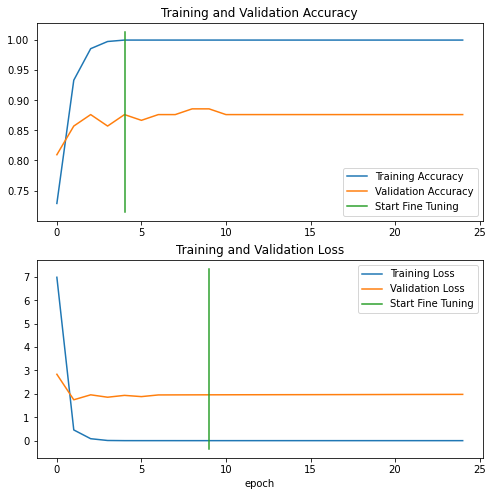

In [143]:
acc += history_fine_effnet.history['accuracy']
val_acc += history_fine_effnet.history['val_accuracy']

loss += history_fine_effnet.history['loss']
val_loss += history_fine_effnet.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
# plt.ylim([0.8, 1])
plt.plot([history_effnet.epoch[-1], history_effnet.epoch[-1]],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
# plt.ylim([0, 1.0])
plt.plot([initial_epochs-1, initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [144]:
loss_test, accuracy_test = new_model_effnet.evaluate(test_dataset)
print("test loss: {:.2f}".format(loss_test))
print("test accuracy: {:.2f}".format(accuracy_test))

11/11 [==============================] - 4s 363ms/step - loss: 1.9887 - accuracy: 0.8190
test loss: 1.99
test accuracy: 0.82


In [159]:
# load an image from file
filename = path + list_photos[2]
image = load_img(filename, target_size=(224, 224))
# convert the image pixels to a numpy array
image = img_to_array(image)
# reshape data for the model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# prepare the image for the VGG model
image = efficientnet_preprocess_input(image)
# predict the probability across all output classes
proba = new_model_effnet.predict(image)

test = pd.DataFrame(proba)
test

0             1             2             3    4             5  \
0  3.846592e-14  3.398258e-22  2.356800e-20  1.032989e-28  1.0  1.319932e-30   

              6  
0  4.598949e-33

In [163]:
test2 = test.idxmax(axis=1)
test2[0]

4

In [164]:
compteur = 0
label_pred = []
for img in tqdm(data.image):
    filename = path + img
    image = load_img(filename, target_size=(224, 224))
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    # reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # prepare the image for the VGG model
    image = efficientnet_preprocess_input(image)
    # predict the probability across all output classes
    proba = new_model_effnet.predict(image)
    # convert the probabilities to class labels
    label = pd.DataFrame(proba).idxmax(axis=1)
    # retrieve the most likely result, e.g. highest probability
    label = label[0]
    label_pred.append(label)
    compteur += 1


100%|██████████| 1050/1050 [02:16<00:00,  7.67it/s]


In [167]:
adjusted_rand_score(labels_true=labels, labels_pred=label_pred)

0.930309835376356

L'ARI est très bon car le modèle à été entrainé sur 80% de ces données, et validé sur 10% des données. Seul 10% des données n'ont pas été vue du tout par le modèle.

### Feature extraction

100%|██████████| 1050/1050 [02:46<00:00,  6.30it/s]


ARI : 0.22
Correspondance des clusters :  [2 0 6 1 4 5 3]
              precision    recall  f1-score   support

           0       0.50      0.01      0.01       150
           1       1.00      0.71      0.83       150
           2       0.98      0.29      0.44       150
           3       0.86      0.17      0.28       150
           4       0.24      1.00      0.38       150
           5       0.99      0.70      0.82       150
           6       1.00      0.87      0.93       150

    accuracy                           0.53      1050
   macro avg       0.80      0.53      0.53      1050
weighted avg       0.80      0.53      0.53      1050



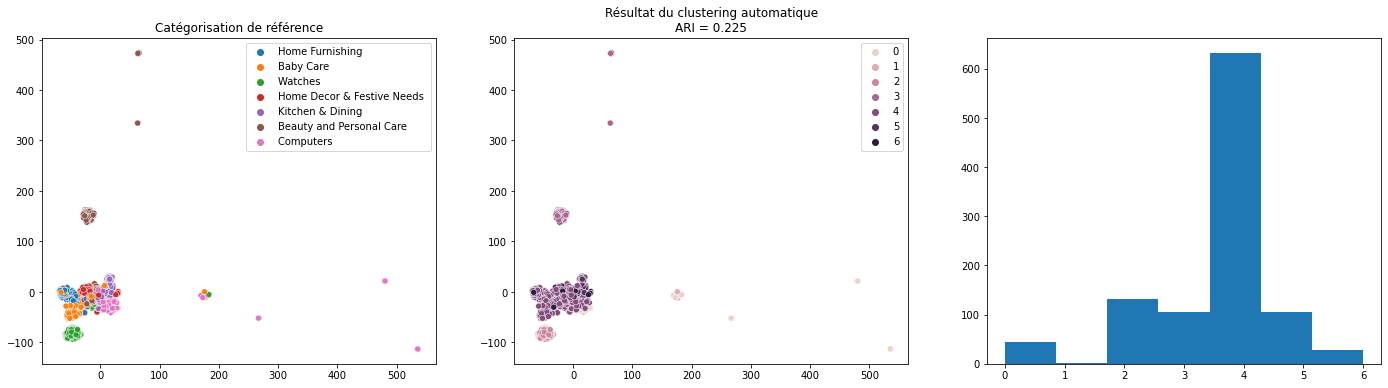

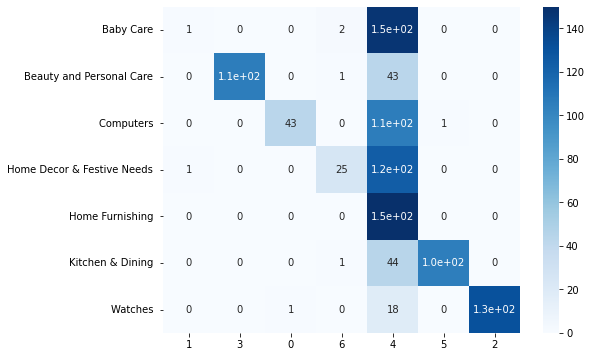

In [140]:
image_features_new_model_effnet_fine = feature_extraction(
    model=new_model_effnet, data=data, path=path, preprocess_input=efficientnet_preprocess_input)

# calcul 7 categories (kmeans)
y_pred_new_model_effnet_fine, ARI_new_model_effnet_fine = clustering_7classes(
    X=image_features_new_model_effnet_fine, labels=labels)

# Visualisation sur tsne
visu_resultats(features=image_features_new_model_effnet_fine,
               y_pred=y_pred_new_model_effnet_fine, ARI=ARI_new_model_effnet_fine)

erreur_attribution(y_true=labels_int, y_pred=y_pred_new_model_effnet_fine)
    

Réduction de dimension
ACP
Dimensions dataset avant réduction PCA :  (1050, 1280)
Dimensions dataset après réduction PCA :  (1050, 313)
ARI : 0.14
Correspondance des clusters :  [1 3 2 5 6 2 1]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       150
           1       1.00      0.71      0.83       150
           2       0.97      0.23      0.38       150
           3       0.62      0.05      0.10       150
           4       0.00      0.00      0.00       150
           5       0.20      1.00      0.33       150
           6       1.00      0.87      0.93       150

    accuracy                           0.41      1050
   macro avg       0.54      0.41      0.37      1050
weighted avg       0.54      0.41      0.37      1050



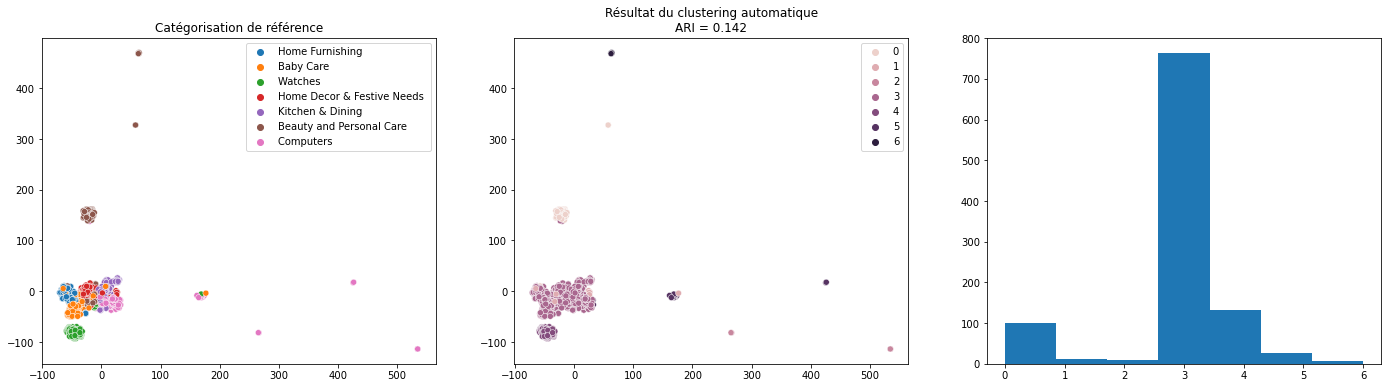

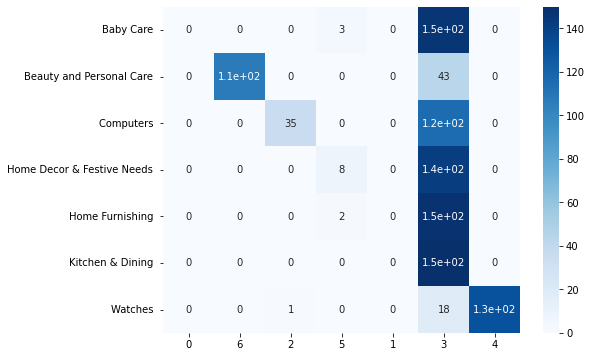

In [168]:
# Réduction de dimension
feat_pca_new_model_effnet_fine = reduction_dimension(X=image_features_new_model_effnet_fine)

# Classification finale
y_pred_new_model_effnet_fine, ARI_new_model_effnet_fine = clustering_7classes(
    X=feat_pca_new_model_effnet_fine, labels=labels)

# Visualisation sur tsne
visu_resultats(feat_pca_new_model_effnet_fine, y_pred=y_pred_new_model_effnet_fine, ARI=ARI_new_model_effnet_fine)

erreur_attribution(y_true=labels_int, y_pred=y_pred_new_model_effnet_fine)

In [141]:
test = EfficientNetB0()
test.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_5 (Rescaling)         (None, 224, 224, 3)  0           input_18[0][0]                   
__________________________________________________________________________________________________
normalization_5 (Normalization) (None, 224, 224, 3)  7           rescaling_5[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization_5[0][0]            
_____________________________________________________________________________________

# CONCLUSION
La technique la plus efficace pour extraire les features et permettre la classification automatique des images est celle de la feature extraction sur le modèle CNN EfficientNet

Les features ainsi créées peuvent donc être exportées pour être combinées aux features issues du texte.

In [188]:
np.savetxt('../01_DATA/image_features_efficientnet.csv', image_features_efficientnet, delimiter=',')
np.savetxt('../01_DATA/feat_pca_efficientnet.csv', feat_pca_efficientnet, delimiter=',')